# Atick and Redlich, 1990. "Towards a theory of early visual processing."  
  
  Here we simulate the receptive field that minimizes redundancy subject to a total variance restraint, translation invariance, and minimum information requirements.

In [1]:
import numpy as np
#from numpy.fft import fft
import info_theory_functions as info
from scipy.optimize import minimize
from scipy import fft, arange
from scipy.stats import sem
from random import randint
from cmath import polar
from numpy.fft import fft2
from numpy.fft import fftshift
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from lnl_model_functions import *


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/scikits/__init__.py:1: UserWarning: Module IPython was already imported from /Users/lmcintosh/Git/ipython/IPython/__init__.pyc, but /Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


Equation 2.4. The one positive solution for the optimal transfer function:

# With the amplitude spectrum from natural images

In [2]:
im_path = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
#im_path = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd01A' # baboons, trees, bushes

In [4]:
ls -1 $im_path | wc -l

     156


In [5]:
def load_images(path, numImages, patchSize=None, acceptedExtensions=['.imc','LUM.mat'], square=False, normalize='subtract'):
    from os import listdir
    from os.path import isfile, join
    import array as ar
    import scipy.io
    
    allfiles = []
    for ext in acceptedExtensions:
        allfiles = allfiles + [f for f in listdir(path) if isfile(join(path,f)) and ext in f]
    if len(allfiles) < numImages:
        print 'Only ' + str(len(allfiles)) + ' files in directory.'
    names    = allfiles[:numImages]
    patches  = []

    for im in names:
        if '.imc' in im:
            fin = open(path+'/'+im, 'rb')
            s   = fin.read()
            fin.close()
            arr = ar.array('H', s)
            arr.byteswap()
            img = np.array(arr, dtype='uint16').reshape(1024,1536)
        elif '.mat' in im:
            fin = scipy.io.loadmat(path+'/'+im)
            arr = fin['LUM_Image']
            # make 0 to 255
            arr = arr - min(arr.flat)
            arr = 255.*arr/max(arr.flat)
            img = np.array(arr, dtype='uint16')
            
        # make patches
        if patchSize:
            img_center = [np.shape(img)[0]/2,np.shape(img)[1]/2]
            img        = img[img_center[0]-patchSize/2:img_center[0]+patchSize/2,img_center[1]-patchSize/2:img_center[1]+patchSize/2]
            
        if square:
            N = min(shape(img))
            N = N - (N % 2) # make even
            img = img[:N,:N]
        
        if normalize == 'subtract':
            # normalize to unit variance and zero mean (originally I did these in opposite order, but this
            # is the official z-scoring order I believe)
            img -= np.mean(img)
            patches.append(img/np.std(img))
        elif normalize == 'divisive':
            # normalize by the mean
            patches.append(img/np.mean(img))
        else:
            patches.append(img)

    return patches

In [6]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (phi, rho)

In [7]:
def rotavg(im):
    '''im can be square 2d numpy array'''
    imShape = shape(im) # NNM
    N       = imShape[0]
    X, Y    = np.meshgrid(range(-N//2,N//2),range(-N//2,N//2))

    theta, rho = cart2pol(X,Y);
    rho = rho.round()
    f   = [mean(im[np.where(rho==r)]) for r in range(N//2+1)] 
        
    return f

In [8]:
def spectrum2d(arr, Fs=1000.0, frequencyFlag=True):
    amp = abs(fftshift(fft2(arr)))/np.prod(arr.shape)
    amp = rotavg(amp)
    n = len(amp)
    #amp = amp/n
    k = arange(n)
    T = n/Fs
    frq = k/(2*T) # two sides frequency range
    #frq = frq[range(n/2)] # one side frequency range
    
    if frequencyFlag:
        #return (frq, [a/n**2 for a in amp])  # should n be squared?
        return (frq, amp)
    else:
        #return [a/n**2 for a in amp]  # should n be squared?
        return amp

## Load original images

In [9]:
numImages = 100
patchSize = None
pixelsToDeg = 92./2
normalize = 'divisive'
averageGanglionSize = 1.5*pixelsToDeg+1 # in pixels

In [10]:
patches = load_images(im_path, numImages, patchSize, square=True, normalize=normalize)

Only 78 files in directory.


## Sample image in degrees

In [11]:
degAxes = [i/pixelsToDeg for i in xrange(patches[0].shape[0])]

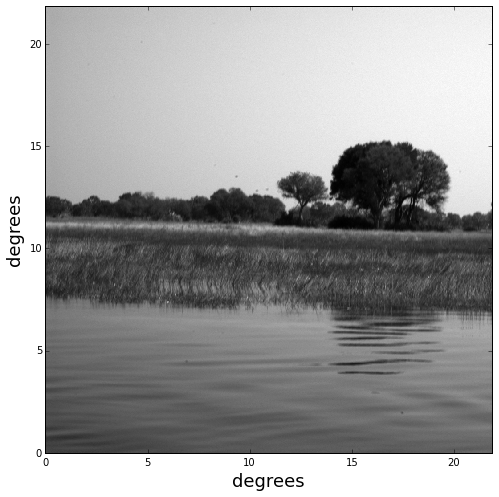

In [12]:
imshow(patches[13], extent=[np.min(degAxes), np.max(degAxes), np.min(degAxes), np.max(degAxes)])
xlabel('degrees',fontsize=18)
ylabel('degrees',fontsize=18)
savefig('example_natural_image.jpg')

In [13]:
amp = abs(fftshift(fft2(patches[0])))
rot = rotavg(amp)
print (shape(amp), shape(rot))

((1006, 1006), (504,))


## log 2d FFT plot of this sample image

#### Highest frequency is then 1/degree_spacing

In [14]:
samplingRate = pixelsToDeg    # Fs
spacing      = 1./pixelsToDeg # T
highest_freq = 1./(2*spacing)

print 'The sampling rate is %s pixels per degree.' %(samplingRate)
print 'The images are sampled at %f degree spacing.' %(spacing)
print 'Highest frequency should be %s 1/deg.' %(highest_freq)

The sampling rate is 46.0 pixels per degree.
The images are sampled at 0.021739 degree spacing.
Highest frequency should be 23.0 1/deg.


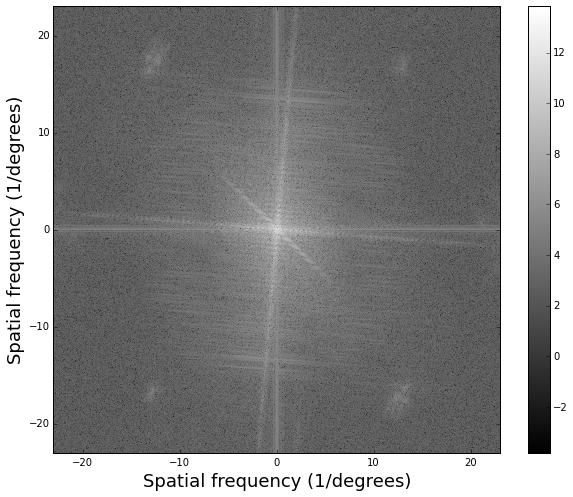

In [15]:
imshow(log(amp), extent=[-highest_freq, highest_freq, -highest_freq, highest_freq])
colorbar()
ylabel('Spatial frequency (1/degrees)',fontsize=18)
xlabel('Spatial frequency (1/degrees)',fontsize=18)

### Compute rotationally averaged amplitude spectrum

In [16]:
allRot  = [spectrum2d(p,Fs=pixelsToDeg,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],Fs=pixelsToDeg,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors = error
originalFreqs = frqRot

In [17]:
print 'Maximum frequency is %f, should be %f' %(np.max(originalFreqs), highest_freq)

Maximum frequency is 22.954365, should be 23.000000


In [18]:
print 'Minimum frequency is %f, should be %f' %(originalFreqs[1], 1./np.max(degAxes))

Minimum frequency is 0.045635, should be 0.045771


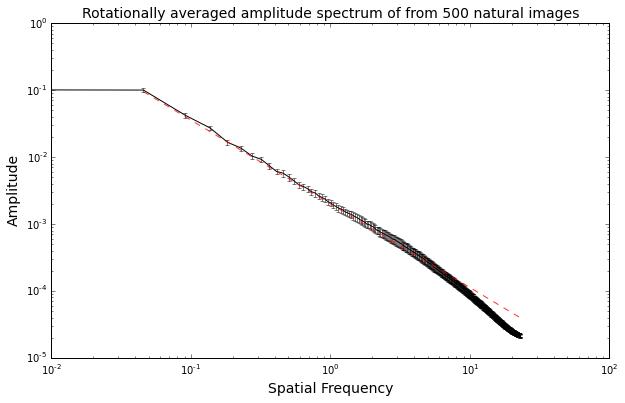

In [19]:
fig,ax = subplots()
fig.set_size_inches((10,6))

ax.errorbar(originalFreqs, originalSpectra, yerr=originalErrors, fmt='none', ecolor='k', capsize=2, capthick=1, alpha=0.5)
ax.plot(originalFreqs, originalSpectra, color='k', alpha=0.99)
# ax.plot(originalFreqs, [1.3/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
# ax.plot(originalFreqs, [0.02/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
ax.plot(originalFreqs[1:], [0.002/f**1.25 for f in originalFreqs[1:]], color='r', linestyle='--', alpha=0.8)

ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')

ax.set_title('Rotationally averaged amplitude spectrum of from 500 natural images', fontsize=14)
ax.set_xlabel('Spatial Frequency', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

#ylim([10e-7,10e-1])
# ylim([10e-4,10e1])
#ylim([10e-5,1])
#savefig('Figures/00 Average power spectrum of original images.png')

#### Sanity check on magnitude scale

In [20]:
print 'Actual DC component is %s, should be %f. E.g., the mean of the first patch is %s' %(originalSpectra[0], np.mean(patches), abs(fft2(patches[0])[0,0]/np.prod(patches[0].shape)))

Actual DC component is 1.0, should be 1.000000. E.g., the mean of the first patch is 1.0


Resolution in 1/degrees

In [21]:
pixelsToDeg/patches[0].shape[0]

0.04572564612326044

# Import David's original receptive field data

Sorry I wasn't able to concatenate all of the files into one matrix. For the ganglion cells the temporal dimension has a delta of 0.005s, while the interneurons have a temporal dimension of 0.01s. All but one of the cells (ganglion and interneuron) have a spatial delta of 0.027mm, the only one that is different is the second horizontal cell which has a spatial delta of 0.022mm.


allGC.txt is space x number x time  
H1A2.txt is time x space x number (first number dimension is a horizontal the last two are amacrine)  
H2.txt is time x space

In [24]:
data_path = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Surround size project/david_receptive_fields'

## Ganglion cells

In [25]:
file_name = data_path + '/allGC.txt'
data_gc   = np.loadtxt(file_name, delimiter="\t")

In [26]:
shape(data_gc)

(8000, 28)

In [27]:
data_gc_reshaped = data_gc.reshape((100,80,28))

<matplotlib.colorbar.Colorbar instance at 0x1033e54d0>

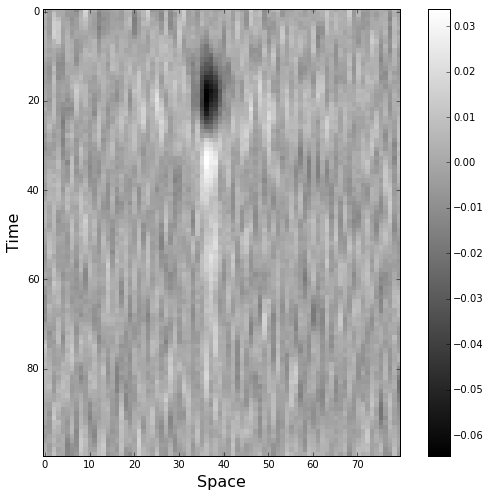

In [28]:
numGCells = 28

imshow(data_gc_reshaped[:,:,0])
xlabel('Space',fontsize=16)
ylabel('Time',fontsize=16)
colorbar()

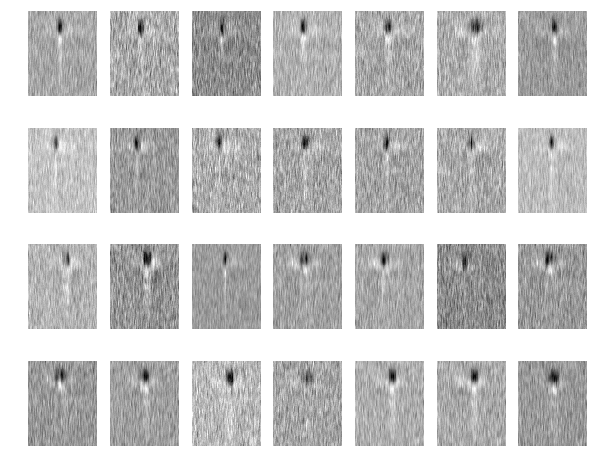

In [29]:
# Visualize the ganglion cell RFs.
num_cols = 7
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        subplot(num_rows, num_cols, plt_idx)
        imshow(data_gc_reshaped[:,:,plt_idx-1])
        pyplot.axis('off')
#         if i == 0:
#             plt.title(cls)


## Horizontal and Amacrine cells

In [30]:
file_name = data_path + '/H1A2.txt'
data_ha   = np.loadtxt(file_name, delimiter="\t")

In [31]:
shape(data_ha)

(150, 80)

In [32]:
data_ha_reshaped = data_ha.reshape((3,50,80))

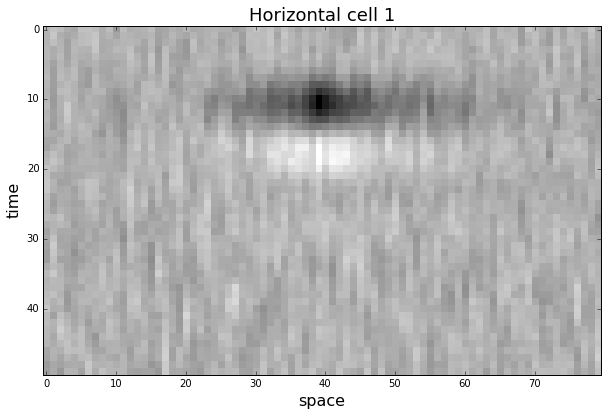

In [33]:
imshow(data_ha_reshaped[0,:,:])
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Horizontal cell 1',fontsize=18)
#colorbar()

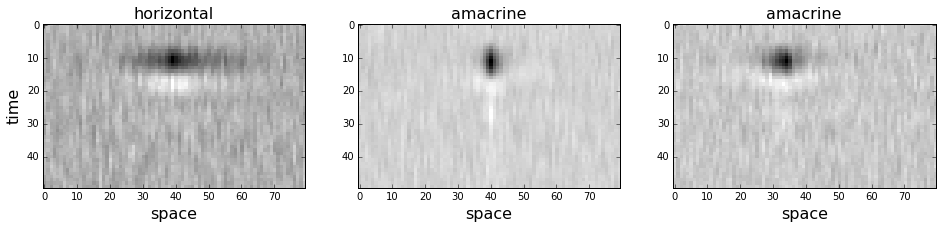

In [34]:
# Visualize the ganglion cell RFs.
classes = ['horizontal','amacrine','amacrine']
num_cols = 3
num_rows = 1
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        subplot(num_rows, num_cols, plt_idx)
        imshow(data_ha_reshaped[plt_idx-1,:,:])
        #plt.axis('off')
        
        if i == 0:
            title(classes[y],fontsize=16)
            xlabel('space',fontsize=16)
        if y == 0:
            ylabel('time',fontsize=16)
            
fig = gcf()
fig.set_size_inches((16,8))

## Get last horizontal cell

In [35]:
file_name = data_path + '/H2.txt'
data_h2   = np.loadtxt(file_name, delimiter="\t")
spacingH2 = 0.022 # mm

In [36]:
shape(data_h2)

(50, 100)

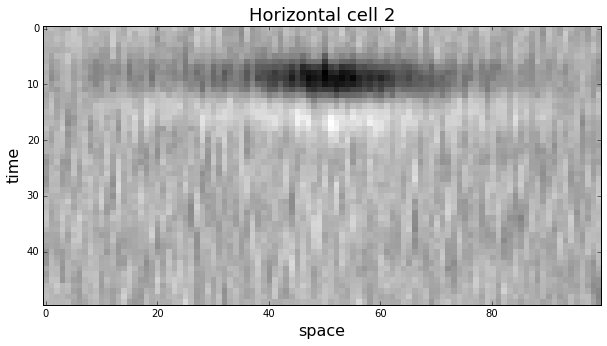

In [37]:
imshow(data_h2)
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Horizontal cell 2',fontsize=18)

## Get bipolar cell

In [38]:
micronsPerDeg = 50.

file_name = data_path + '/B1.txt'
data_b1   = np.loadtxt(file_name, delimiter="\t")
file_name = data_path + '/B2.txt'
data_b2   = np.loadtxt(file_name, delimiter="\t")
spacingB1 = 1000*0.022 # mm to microns
spacingB2 = 1000*0.022 # mm to microns
spaceB1   = [i*spacingB1 for i in np.linspace(-data_b1.shape[1]/2, data_b1.shape[1]/2,data_b1.shape[1])]
spaceB2   = [i*spacingB2 for i in np.linspace(-data_b2.shape[1]/2, data_b2.shape[1]/2,data_b2.shape[1])]
spaceB1   = array(spaceB1)/micronsPerDeg # degrees
spaceB2   = array(spaceB2)/micronsPerDeg # degrees
FsB1      = spaceB1[1]-spaceB1[0]
FsB2      = spaceB2[1]-spaceB2[0]

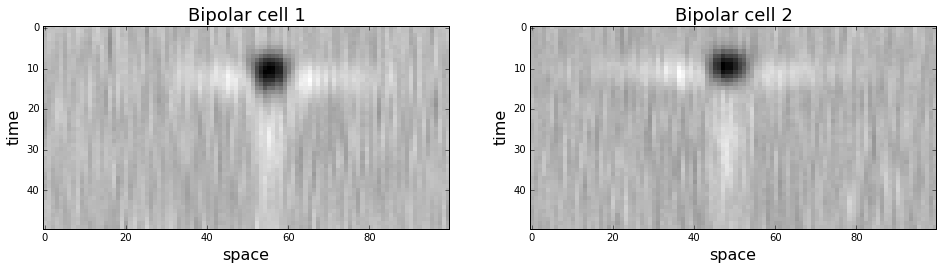

In [39]:
fig = gcf()
fig.set_size_inches((16,4))
subplot(1,2,1)
imshow(data_b1) #, extent=(spaceB1[0],spaceB1[-1],0,40))
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Bipolar cell 1',fontsize=18)

subplot(1,2,2)
imshow(data_b2)
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Bipolar cell 2',fontsize=18)

In [40]:
pca_b1 = PCA(n_components=2)
pca_b1.fit(data_b1)

PCA(copy=True, n_components=2, whiten=False)

In [41]:
pca_b2 = PCA(n_components=2)
pca_b2.fit(data_b2[13:,:])

PCA(copy=True, n_components=2, whiten=False)

In [42]:
print pca_b1.explained_variance_ratio_

[ 0.78233735  0.07530592]


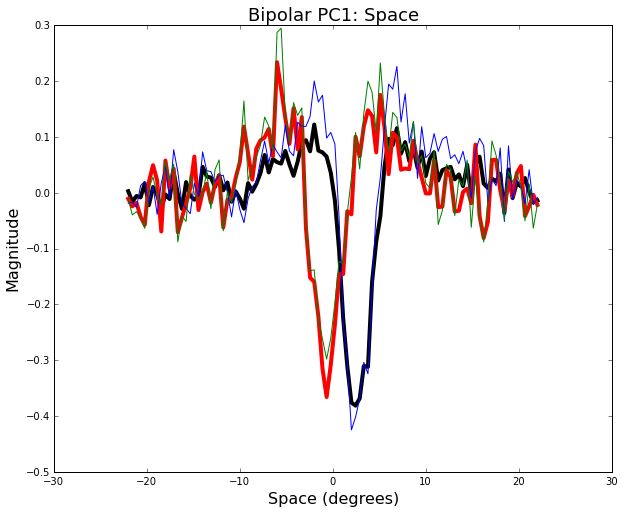

In [43]:
plot(spaceB1,pca_b1.components_[0],'k',linewidth=4)
plot(spaceB2, -pca_b2.components_[0],'r',linewidth=4)
plot(spaceB1, 10*data_b1[14,:])
plot(spaceB2, 15*data_b2[14,:])
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('Bipolar PC1: Space',fontsize=18)

# Ganglion cell

## These are noisy. Use PCA

In [44]:
pca = PCA(n_components=2)
pca.fit(data_gc_reshaped[:,:,0])

PCA(copy=True, n_components=2, whiten=False)

In [45]:
print pca.explained_variance_ratio_

[ 0.48194427  0.06614812]


In [46]:
spatialDelta = 0.027 # mm
space = np.linspace(-spatialDelta*data_gc_reshaped.shape[1]/2,spatialDelta*data_gc_reshaped.shape[1]/2,data_gc_reshaped.shape[1])
space = space*1000. # microns
space = space/micronsPerDeg # degrees
Fs    = space[1]-space[0]

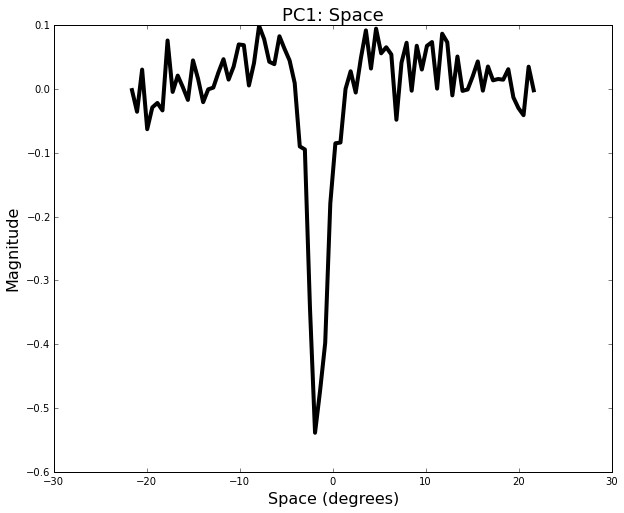

In [47]:
plot(space,pca.components_[0],'k',linewidth=4)
#plot(spaceB1, pca_b1.components_[0],'r',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [48]:
data_gc_reshaped.shape

(100, 80, 28)

In [49]:
pca.components_[0].shape

(80,)

In [50]:
pca_gcs = np.zeros((data_gc_reshaped.shape[2], data_gc_reshaped.shape[1]))
for g in range(data_gc_reshaped.shape[2]):
    pca = PCA(n_components=1)
    pca.fit(data_gc_reshaped[:,:,g])
    if np.max(pca.components_[0]) > 0.3:
        sgn = -1
    else:
        sgn = 1
    pca_gcs[g,:] = sgn*pca.components_[0]

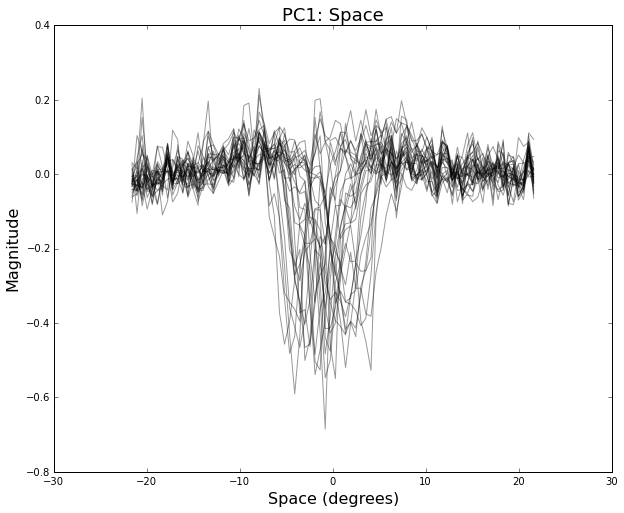

In [51]:
plot(space,pca_gcs.T,'k',linewidth=1, alpha=.4)
#plot(spaceB1, pca_b1.components_[0],'r',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [52]:
Fs

0.54683544303797404

In [53]:
ganglion_pca = pca.components_[0]

# Horizontal cell

## Look at a 1d spatial PCA component of 1st horizontal cell

In [54]:
pca = PCA(n_components=2)
pca.fit(data_ha_reshaped[0,:,:])

PCA(copy=True, n_components=2, whiten=False)

In [55]:
print pca.explained_variance_ratio_

[ 0.74921812  0.04016211]


In [56]:
spatialDelta = 0.027 # mm
micronsPerDeg = 50.
space_h1 = np.linspace(-spatialDelta*data_ha_reshaped.shape[2]/2,spatialDelta*data_ha_reshaped.shape[2]/2,data_ha_reshaped.shape[2])
space_h1 = space_h1*1000. # microns
space_h1 = space_h1/micronsPerDeg # degrees
Fs    = space_h1[1]-space_h1[0]

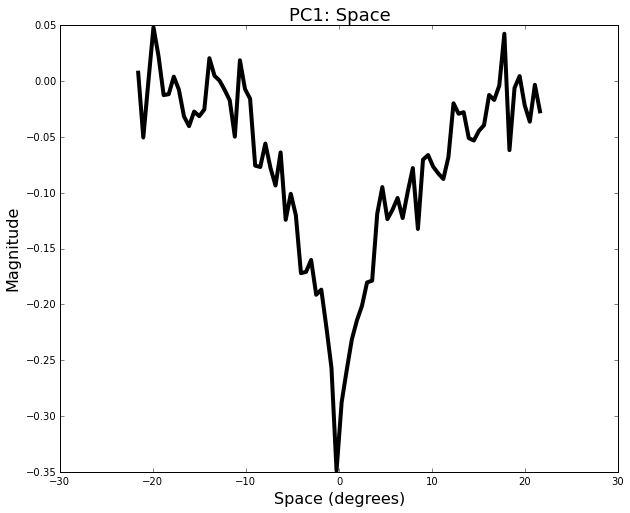

In [57]:
plot(space,pca.components_[0],'k',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [58]:
horz_pca = pca.components_[0]
pca_h1 = pca.components_[0]

In [59]:
exptFilterF = abs(fftshift(fft(pca.components_[0])))
# exptFreqsFwd = [i*Fs/len(exptFilterF) for i in range(len(exptFilterF)/2)]
# exptFreqsRwd = [-a for a in exptFreqsFwd[::-1]]
# exptFreqs    = exptFreqsRwd + exptFreqsFwd

exptFreqs = np.fft.fftshift(np.fft.fftfreq(len(exptFilterF),Fs))
exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]

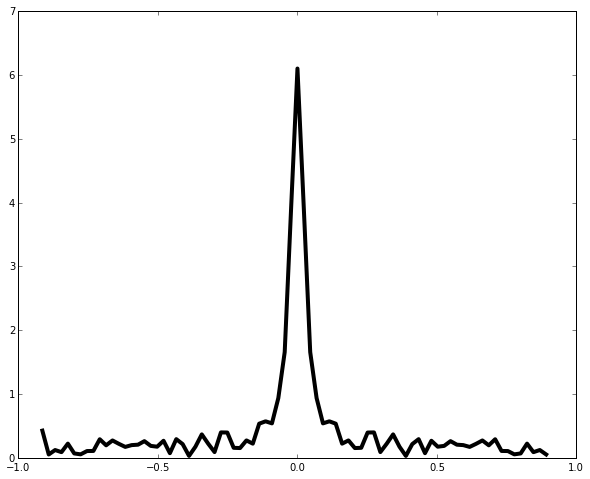

In [60]:
plot(exptFreqs,exptFilterF,'k',linewidth=4)

In [61]:
# get one sided fft
exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]
exptFilterFwd = exptFilterF[len(exptFilterF)/2:]

# normalize both experimental and ideal filter
exptFilterNorm = exptFilterFwd/np.max(exptFilterFwd)
# idealFilterNorm = filt/np.max(filt[~isnan(filt)])

plot(originalFreqs, idealFilterNorm, 'r--', linewidth=3) #[15.*a for a in idealFreqsFwd]
plot(exptFreqsFwd, 1-exptFilterNorm, 'k', linewidth=3)
xlabel('Spatial frequency (deg' + r'$^{-1}$' +')',fontsize=16)

NameError: name 'idealFilterNorm' is not defined

In [62]:
horz_freqs = exptFreqsFwd
horz_amp   = exptFilterFwd

# 2nd Horizontal cell

In [63]:
pca = PCA(n_components=2)
pca.fit(data_h2)

PCA(copy=True, n_components=2, whiten=False)

In [64]:
print pca.explained_variance_ratio_

[ 0.77943321  0.04176094]


In [65]:
data_h2.shape

(50, 100)

In [66]:
micronsPerDeg = 50.
space_h2 = np.linspace(-spacingH2*data_h2.shape[1]/2,spacingH2*data_h2.shape[1]/2,data_h2.shape[1])
space_h2 = space_h2*1000. # microns
space_h2 = space_h2/micronsPerDeg # degrees
Fs    = space_h2[1]-space_h2[0]

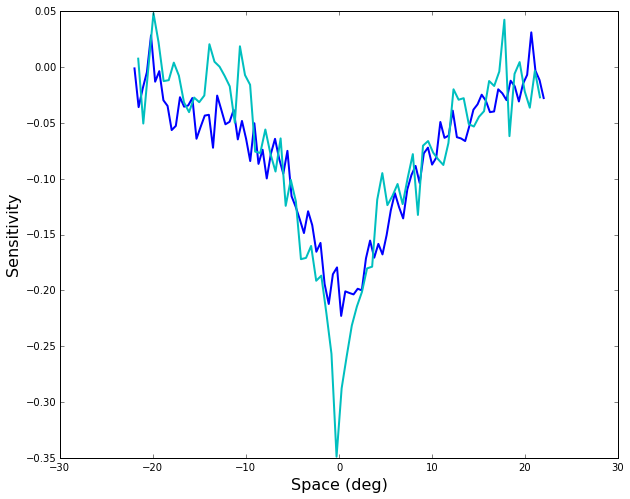

In [67]:
pca_h2 = pca.components_[0]
plot(space_h2, pca_h2, 'b', linewidth=2)
plot(space_h1, pca_h1, 'c', linewidth=2)
xlabel('Space (deg)', fontsize=16)
ylabel('Sensitivity', fontsize=16)

### Generate horizontal cell average, and error bars

<Container object of 3 artists>

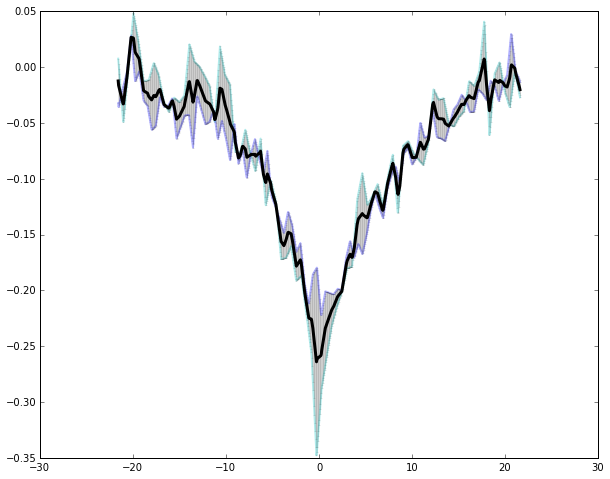

In [68]:
nPoints    = 1000
range_horz = [np.max([np.min(space_h1), np.min(space_h2)]), np.min([np.max(space_h1), np.max(space_h2)])]
space_horz = np.linspace(range_horz[0], range_horz[1], nPoints)
interp_h1  = interp1d(space_h1, pca_h1, kind='linear')
interp_h2  = interp1d(space_h2, pca_h2, kind='linear')
common_h1  = interp_h1(space_horz)
common_h2  = interp_h2(space_horz)
plot(space_horz, common_h1, 'c', linewidth=2, alpha=0.3)
plot(space_horz, common_h2, 'b', linewidth=2, alpha=0.3)
plot(space_horz, np.mean(np.vstack([common_h1, common_h2]), axis=0), 'k', linewidth=3)
errorbar(space_horz, np.mean(np.vstack([common_h1, common_h2]), axis=0), yerr=sem(np.vstack([common_h1, common_h2])), fmt='none', ecolor='k', capsize=1, capthick=1, alpha=0.1)

# Amacrine cell

In [69]:
pca = PCA(n_components=2)
pca.fit(data_ha_reshaped[1,:,:])

PCA(copy=True, n_components=2, whiten=False)

In [70]:
print pca.explained_variance_ratio_

[ 0.79972496  0.04208702]


In [71]:
spatialDelta = 0.027 # mm
micronsPerDeg = 50.
space = np.linspace(-spatialDelta*data_ha_reshaped.shape[2]/2,spatialDelta*data_ha_reshaped.shape[2]/2,data_ha_reshaped.shape[2])
space = space*1000. # microns
space = space/micronsPerDeg # degrees
Fs    = space[1]-space[0]

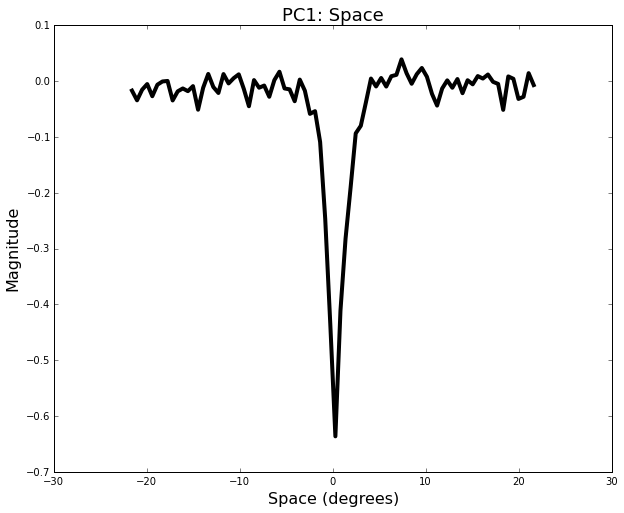

In [72]:
plot(space,pca.components_[0],'k',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [73]:
ama_pca = pca.components_[0]

In [74]:
exptFilterF = abs(fftshift(fft(pca.components_[0])))
# exptFreqsFwd = [i*Fs/len(exptFilterF) for i in range(len(exptFilterF)/2)]
# exptFreqsRwd = [-a for a in exptFreqsFwd[::-1]]
# exptFreqs    = exptFreqsRwd + exptFreqsFwd

exptFreqs = np.fft.fftshift(np.fft.fftfreq(len(exptFilterF),Fs))
exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]

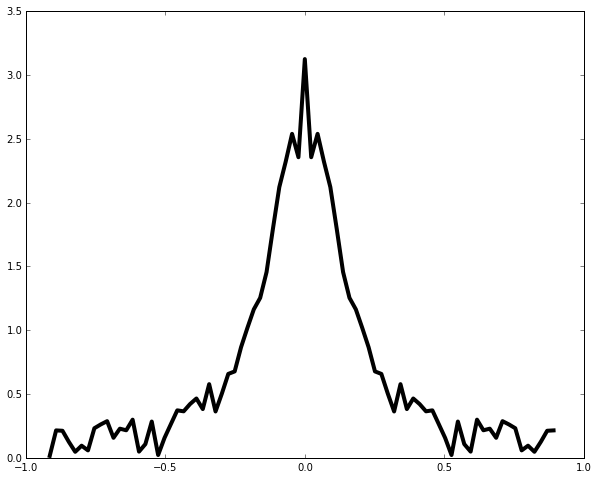

In [75]:
plot(exptFreqs,exptFilterF,'k',linewidth=4)

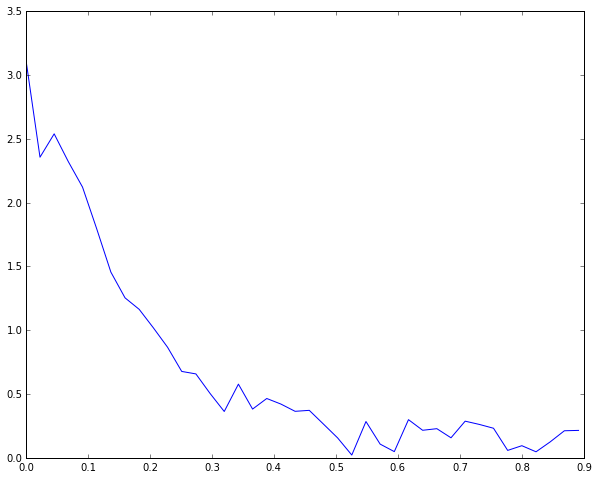

In [76]:
plot(exptFreqsFwd,exptFilterF[len(exptFilterF)/2:])

In [77]:
ama_freqs = exptFreqsFwd
ama_amp   = exptFilterFwd

## Get all amacrine cells

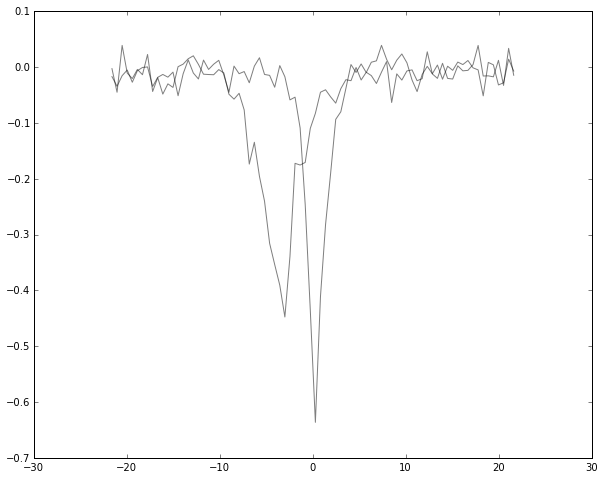

In [78]:
pca_amas = np.zeros((2, data_ha_reshaped.shape[2]))
for ama in range(pca_amas.shape[0]):
    pca = PCA(n_components=1)
    pca.fit(data_ha_reshaped[ama+1,:,:])
    pca_amas[ama] = pca.components_[0]
    
plot(space, pca_amas.T, 'k', linewidth=1, alpha=0.5)


## Normalize amacrine and horizontal filters

In [79]:
ama_amp /= np.max(ama_amp)
#gc_amp  /= np.max(gc_amp)
horz_amp /= np.max(horz_amp)

## Model projective fields

In [80]:
new_horz_proj = [exp(-abs(t)/(118/22)) for t in np.linspace(np.min(space),np.max(space),len(space))]

In [81]:
new_ama_proj = [exp(-abs(t)/(78/22)) for t in np.linspace(np.min(space),np.max(space),len(space))]

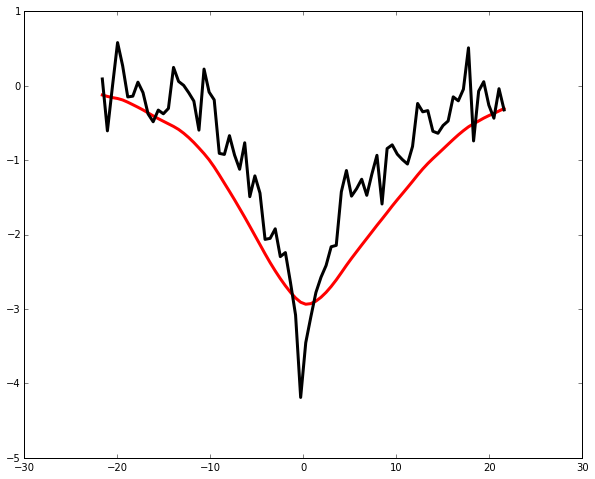

In [82]:
plot(space,np.convolve(new_horz_proj, horz_pca, mode='same'),'r',linewidth=3)
plot(space,12*horz_pca,'k',linewidth=3)

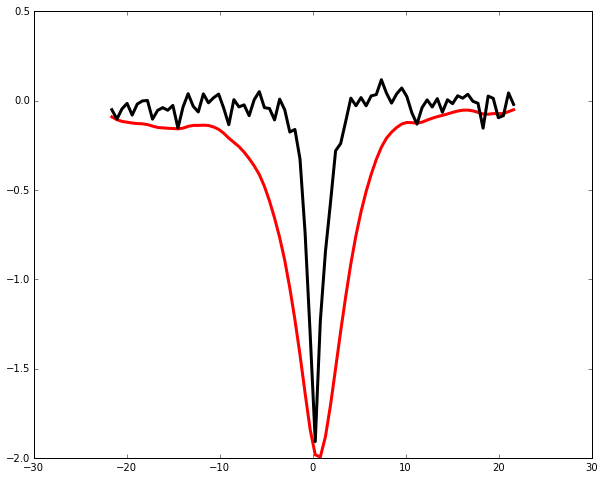

In [83]:
plot(space,np.convolve(new_ama_proj, ama_pca, mode='same'),'r',linewidth=3)
plot(space,3*ama_pca,'k',linewidth=3)

In [84]:
horz_rf_proj_new = np.convolve(new_horz_proj, horz_pca, mode='same')
horz_rf_proj_new /= abs(np.min(horz_rf_proj_new))

In [85]:
ama_rf_proj_new = np.convolve(new_ama_proj, ama_pca, mode='same')
ama_rf_proj_new /= abs(np.min(ama_rf_proj_new))

In [86]:
one_sided_horz_proj_fft = abs(fft(horz_rf_proj_new))[:len(horz_rf_proj_new)/2]
one_sided_horz_proj_fft /= np.max(one_sided_horz_proj_fft)

In [87]:
one_sided_ama_proj_fft = abs(fft(ama_rf_proj_new))[:len(ama_rf_proj_new)/2]
one_sided_ama_proj_fft /= np.max(one_sided_ama_proj_fft)

In [88]:
bipolar_fft = fftshift(abs(fft(pca_b1.components_[0])))[len(pca_b1.components_[0])/2:]
bipolar_fft /= np.max(bipolar_fft)
bipolarFreqs = np.fft.fftshift(np.fft.fftfreq(len(fft(pca_b1.components_[0])),Fs))
bipolarFreqsFwd = bipolarFreqs[len(bipolarFreqs)/2:]

## Create function for plotting the above, just given input and output noise, and the weightings

In [89]:
def getLambda(r0, inputNoise, outputNoise):
    
    N = inputNoise
    def lhs(lam):
        #return np.sum(np.log([np.sqrt(r/(2*lam*inputNoise**2))+np.sqrt(1+(r/2*lam*inputNoise**2)) for r in R_0]))
        tmp = r0/(2 * lam * N**2).astype(complex)
        return real(np.sum(np.log(np.sqrt(tmp) + np.sqrt(1 + tmp))))
    
    #R = np.array(R_0) + inputNoise**2
    r0 = np.array(r0)
    r  = r0 + N**2
    #rhs = 0.5*np.sum(np.log([(r*(inputNoise**2 + outputNoise**2))/(inputNoise**2 * (r + outputNoise**2)) for r in R]))
    rhs = 0.5 * np.sum(np.log((r/(N**2)) * ((N**2 + outputNoise**2)/(r + outputNoise**2))))
    
    def relativeDifference(lam):
        left = lhs(lam)
        return abs(left-rhs)/(abs(left) + abs(rhs))
    
    lam = 5*rand(1)
    res = minimize(relativeDifference, x0=lam, method='nelder-mead')
    
    return res.x, res.fun

In [90]:
def uniqueSoln(r0, inputNoise, outputNoise, verbose=True):
    '''R_0 is input covariance matrix
       R is R_0 + N^2 delta_n,m'''
    #R = np.array(R_0) + inputNoise**2 #* np.eye(*R_0.shape)
    
    #import pdb
    #pdb.set_trace()
    
    N  = inputNoise
    r0 = np.array(r0)
    r  = r0 + N**2
    
    lam, relErr = getLambda(r0, inputNoise, outputNoise)
    if verbose:
        print 'The relative error from this choice of Lagrangian multiplier is %s.' %(relErr)
        
    #import pdb
    #pdb.set_trace()
    
    tmp = 1 + (2 * lam * N**2)/r0.astype(complex)
    f = ((1. / N**2) * (.5 * r0/r * (1 + np.sqrt(tmp)) - 1)).astype(complex)
    
    return real(outputNoise * np.sqrt(f))

In [91]:
def experimentVsIdeal(inputNoise=0.1, outputNoise=0.4, center_weighting=2.1, surround_weighting=0.1,
                      horz_weighting=0.5, ama_weighting=0.5, space=space, originalFreqs=originalFreqs,
                      originalSpectra=originalSpectra, horz_rf_proj_new=horz_rf_proj_new,
                      ama_rf_proj_new=ama_rf_proj_new, centerWidth=.5, interpolation='fit', 
                      returnFlag=False, plotFlag=True, verbose=True):
    # EXPERIMENTAL
    # make surround
    surround       = horz_weighting * horz_rf_proj_new + ama_weighting * ama_rf_proj_new

    # make center
    center         = gaussian(x=space, sigma=centerWidth, mu=space[surround==np.min(surround)]) # gaussian
    #center           = center_weighting * np.where(surround==np.min(surround), 1, 0) # delta function

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weighting * center + surround_weighting * surround
    
    # FFT of RF
    rf_f_two_sided = abs(fftshift(fft(rf)))
    rf_f_one_sided = rf_f_two_sided[len(rf_f_two_sided)/2:]

    rf_freqs_two_sided = np.fft.fftshift(np.fft.fftfreq(len(rf_f_two_sided),Fs))
    rf_freqs_one_sided = rf_freqs_two_sided[len(rf_freqs_two_sided)/2:]
    
    
    # IDEAL
    if interpolation == 'linear':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='linear')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'cubic':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='cubic')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'fit':
        def func(x, a, b, c):
            return a/(x**b) + c
        popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 5000)[1:]
        moreSpectra = func(moreFreqs, *popt)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation is None:
        idealFilter = uniqueSoln(originalSpectra, inputNoise, outputNoise, verbose=verbose)
        
        
    
    if plotFlag:
        plot(moreFreqs, idealFilter, 'r.', linewidth=2)
        plot(rf_freqs_one_sided, rf_f_one_sided, 'k.', linewidth=2)
    
    if returnFlag:
        try:
            return moreFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided
        except:
            return originalFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided

In [92]:
inputNoise=.018
outputNoise=.005
totalNoise = inputNoise + outputNoise

moreFreqs1, idealFit, horzOnlyF, horzOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit', originalSpectra=(originalSpectra)**2)
moreFreqs1, idealFit, amaOnlyF, amaOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=1.0, horz_weighting=0.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit', originalSpectra=(originalSpectra)**2)

flag = 'exp'

if flag == 'interp':
    # interpolate horizontal and amacrine projective field filters in frequency space
    horzInterpolate = interp1d(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), kind='slinear')
    amaInterpolate  = interp1d(amaOnlyF,  1-amaOnlyFilter/np.max(amaOnlyFilter), kind='slinear')

    horzInterpolate_x = np.linspace(np.min(horzOnlyF), np.max(horzOnlyF), len(moreFreqs1))
    amaInterpolate_x  = np.linspace(np.min(amaOnlyF), np.max(amaOnlyF), len(moreFreqs1))
elif flag == 'exp':
    def func(x, a, b, c):
        # exponential
        y = a * np.exp(-b * x) + c

        # power law
        #y = a / x**b + c
        #y[x==0] = np.max(y[np.isfinite(y)])

        return 1 - y/np.max(y)

    popt_horz, pcov_horz = curve_fit(func, horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter))
    popt_ama, pcov_ama   = curve_fit(func, amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter))
    
    horzInterpolate_x = np.linspace(np.min(horzOnlyF), np.max(horzOnlyF), len(moreFreqs1))
    amaInterpolate_x  = np.linspace(np.min(amaOnlyF), np.max(amaOnlyF), len(moreFreqs1))
    
    horzExpFit = func(horzInterpolate_x, *popt_horz)
    amaExpFit  = func(amaInterpolate_x, *popt_ama)

The relative error from this choice of Lagrangian multiplier is 2.00581559338e-10.
The relative error from this choice of Lagrangian multiplier is 4.1288710589e-10.


In [93]:
def func(x, a, b, c):
    return a/(x**b) + c
popt, pcov  = curve_fit(func, originalFreqs[1:], (originalSpectra**2)[1:])
moreFreqs   = np.linspace(0., np.max(originalFreqs), 5000)[1:]
moreSpectra = func(moreFreqs, *popt)

inputNoises  = np.logspace(-1.8,-0.8,10)
outputNoises = np.logspace(-1.8,-0.8,10)
filts_new = {}
for N in inputNoises:
    for N_del in outputNoises:
        filts_new[(N,N_del)] = uniqueSoln(moreSpectra, N, N_del, verbose=False)

The total noise is 0.023000.


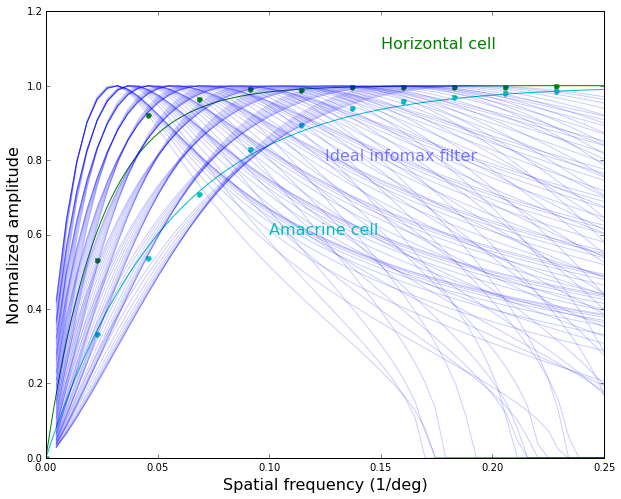

In [95]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', markersize=10)
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.', markersize=10)
if flag == 'interp':
    plot(horzInterpolate_x, horzInterpolate(horzInterpolate_x), 'g')
    plot(amaInterpolate_x, amaInterpolate(amaInterpolate_x), 'c')
elif flag == 'exp':
    plot(horzInterpolate_x, horzExpFit, 'g')
    plot(amaInterpolate_x, amaExpFit, 'c')
    
for k in filts_new.keys():
    plot(moreFreqs, filts_new[k]/np.max(filts_new[k]), 'b', alpha=0.2)
#plot(moreFreqs1, idealFit/np.max(idealFit), 'b', linewidth=3, alpha=0.5)
xlim([0,0.25])
xlabel('Spatial frequency (1/deg)', fontsize=16)
ylabel('Normalized amplitude', fontsize=16)
annotate('Amacrine cell', [0.1, 0.6], fontsize=16, color='c')
annotate('Horizontal cell', [0.15, 1.1], fontsize=16, color='g')
annotate('Ideal infomax filter', [0.125, 0.8], fontsize=16, color='b', alpha=0.5)
print 'The total noise is %f.' %(totalNoise)
#mpld3.display()

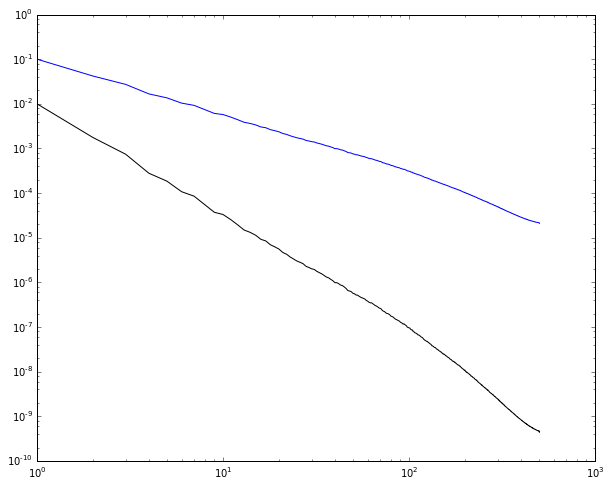

In [96]:
plot(originalSpectra, 'b')
plot(originalSpectra**2,'k')
yscale('log')
xscale('log')